In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from run_evolution import folder_evol
from analytical_results import fT00, fT01, fT11, fj0, fj1, fnu, fLn
from ploting import plot_heatmaps

save = False

In [2]:
g = 1
v, Q = 1, 1
tol, method = 1e-6, '12site'
#
ms = [0.7, 1.0]
mg = [g * x for x in ms]
NaDdt = [(1024, 0.0625, 256, 1/16), (1024, 0.0625, 256, 1/32),]

data = {}

for m in ms:
    for N, a, D, dt in NaDdt:
        D0 = D
        try:
            folder = folder_evol(g, m, a, N, v, Q, D0, dt, D, tol, method, mkdir=False)
            data[m, N, a, D, dt] = np.load(folder / f"results.npy", allow_pickle=True).item()
        except FileNotFoundError:
            pass

In [3]:
for x in data.keys():
    print(x)

(0.7, 1024, 0.0625, 256, 0.0625)
(0.7, 1024, 0.0625, 256, 0.03125)
(1.0, 1024, 0.0625, 256, 0.0625)
(1.0, 1024, 0.0625, 256, 0.03125)


In [4]:
NUM_COLORS = 2
cm = plt.get_cmap('gist_rainbow')
colors = [cm(i / NUM_COLORS) for i in range(NUM_COLORS)]
lines = ['--', '-', ':']

In [5]:
def get_tsm(signals, ev):
    tm = signals["time"]
    mask = tm > -1
    tm = tm[mask]
    ee = signals[ev][mask]
    ee = ee - ee[0, :]
    ee = (ee[:, 0::2] + ee[:, 1::2]) / 2  # average over 2*n and 2*n+1
    mid = (ee[:, N//4] +ee[:, N//4-1])/2
    return tm, ee, mid


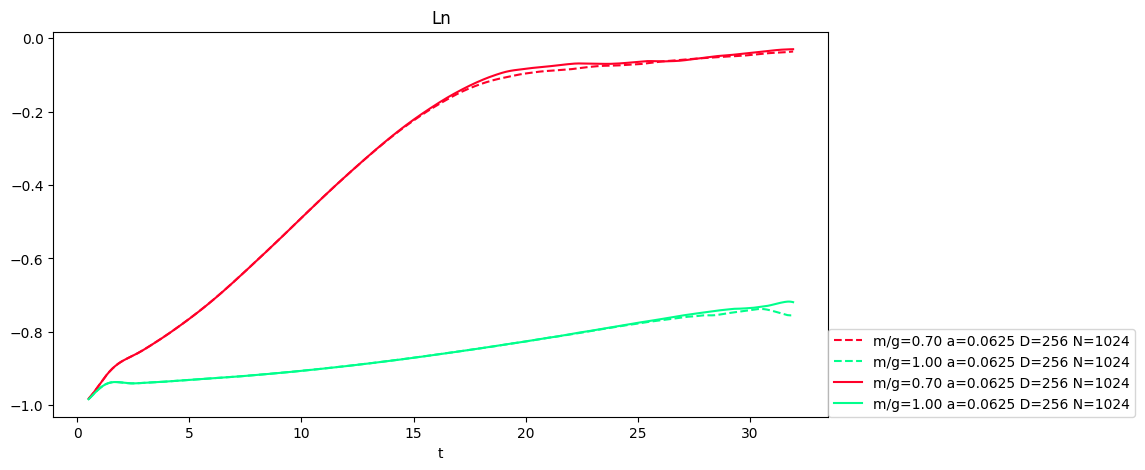

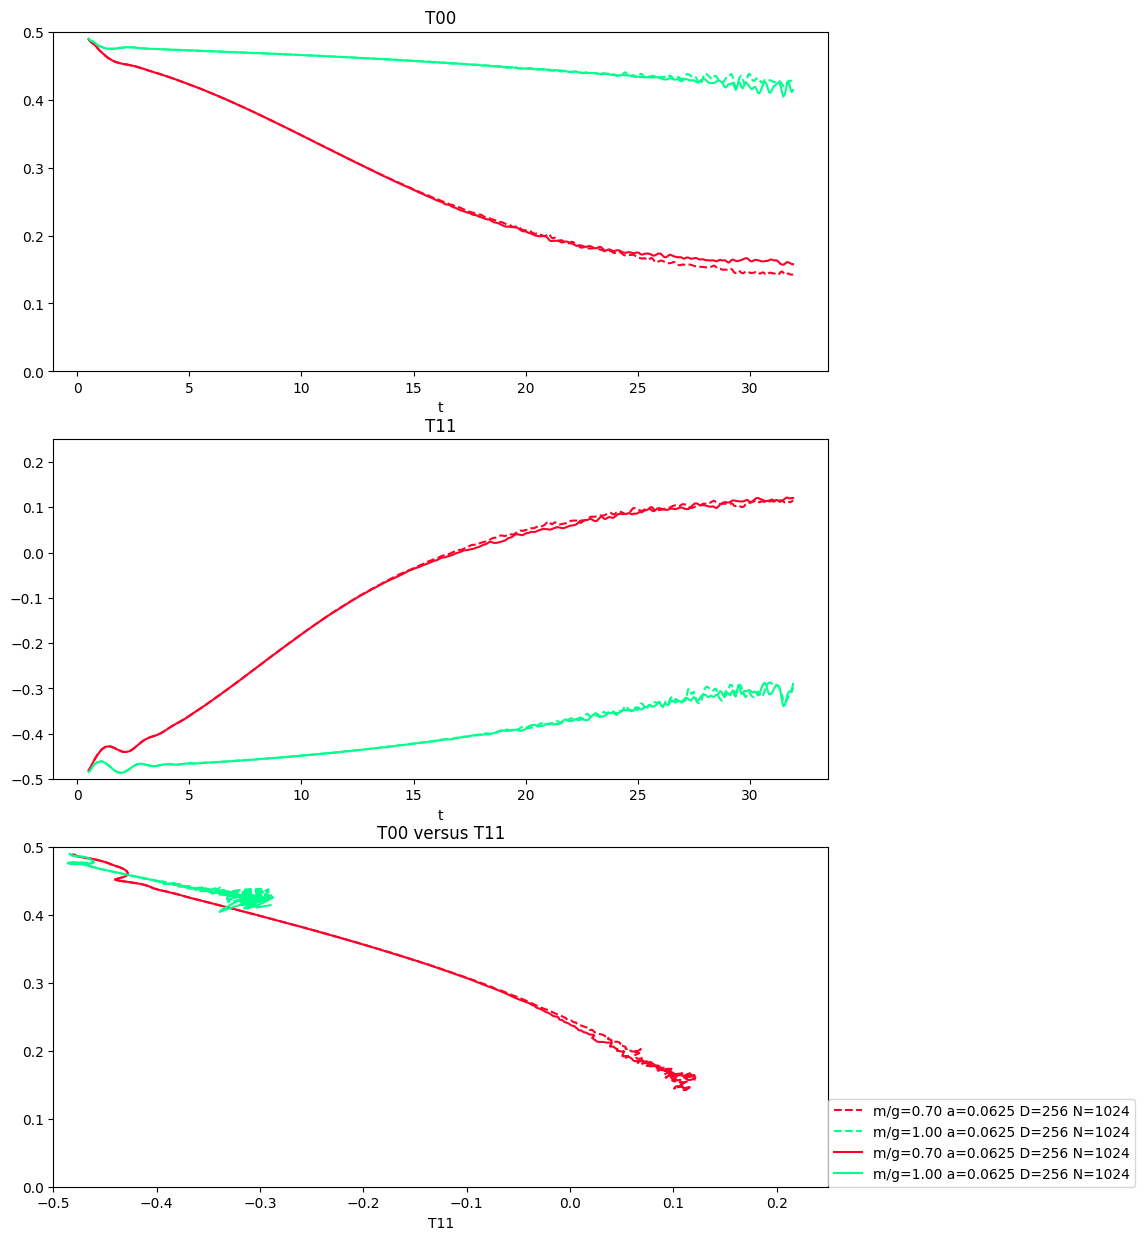

In [6]:
plt.figure(figsize=(10, 5))

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        try:
            tm, ee, mid = get_tsm(data[m, N, a, D, dt], 'Ln')
            line, = plt.plot(tm[8:-1], mid[8:-1], lines[j], color=colors[i])
            line.set_label(f'{m/g=:.2f} {a=} {D=} {N=}')
            np.savetxt(f'Ln_{m=:.2f}.txt', np.column_stack([tm[8:-1], mid[8:-1]]))
        except KeyError:
            pass

plt.legend(loc=(1,0))
plt.xlabel('t')
plt.title('Ln')

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        try:
            tm, ee, midE = get_tsm(data[m, N, a, D, dt], 'T00')
            tm, ee, midp = get_tsm(data[m, N, a, D, dt], 'T11')
            ax[0].plot(tm[8:-1], midE[8:-1], lines[j], color=colors[i], label=f'{m/g=:.2f} {a=} {D=} {N=}')
            ax[1].plot(tm[8:-1], midp[8:-1], lines[j], color=colors[i], label=f'{m/g=:.2f} {a=} {D=} {N=}')
            ax[2].plot(midp[8:-1], midE[8:-1], lines[j], color=colors[i], label=f'{m/g=:.2f} {a=} {D=} {N=}')
            if save:
                np.savetxt(f'T00_vs_t_{m=:.2f}.txt', np.column_stack([tm[8:-1], midE[8:-1]]))
                np.savetxt(f'T11_vs_t_{m=:.2f}.txt', np.column_stack([tm[8:-1], midp[8:-1]]))
                np.savetxt(f'T00_vs_T11_{m=:.2f}.txt', np.column_stack([midp[8:-1], midE[8:-1]]))
        except KeyError:
            pass

ax[0].set_title('T00')
ax[1].set_title('T11')
ax[2].set_title('T00 versus T11')

ax[0].set_xlabel('t')
ax[1].set_xlabel('t')
ax[2].set_xlabel('T11')

ax[0].set_ylim([0, 0.5])
ax[1].set_ylim([-0.5, 0.25])
ax[2].set_xlim([-0.5, 0.25])
ax[2].set_ylim([0, 0.5])

ax[2].legend(loc=(1, 0))


In [7]:
# test energy from MPO vs T00
for i, m in enumerate(ms):
    for j, (N, a, D, dt) in enumerate(NaDdt):
        try:
            mask = data[m, N, a, D, dt]["time"] > -1  # when some points not calculated yet
            x1 = np.sum(data[m, N, a, D, dt]["T00"][mask, :], axis=1) * a
            x2 = data[m, N, a, D, dt]["energy"][mask]
            assert np.max(np.abs((np.abs(1 - x1 / x2) ))) < 1e-8
        except KeyError:
            pass


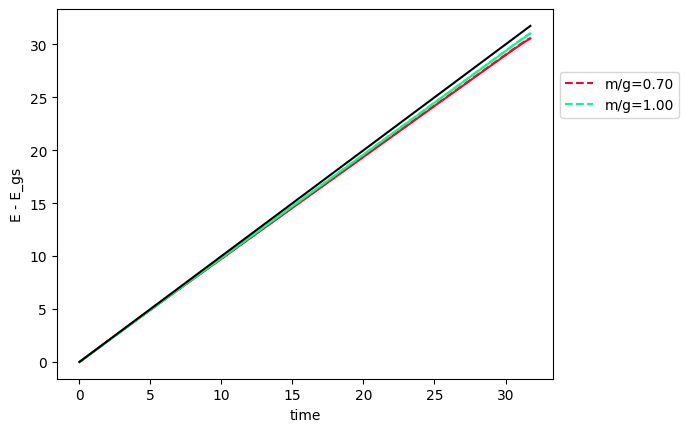

In [8]:
for i, m in enumerate(ms):
    for j, (N, a, D, dt) in enumerate(NaDdt):
        try:
            tm = data[m, N, a, D, dt]["time"]
            mask = tm > -1
            tm = tm[mask]
            en = data[m, N, a, D, dt]["energy"][mask]
            line, = plt.plot(tm[:-4], en[:-4] - en[0], lines[j], color=colors[i],)
            if j == 0:
                line.set_label(f"{m/g=:0.2f}")
        except KeyError:
            pass


plt.plot(tm[:-4], tm[:-4], '-k')

plt.xlabel('time')
plt.ylabel('E - E_gs')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

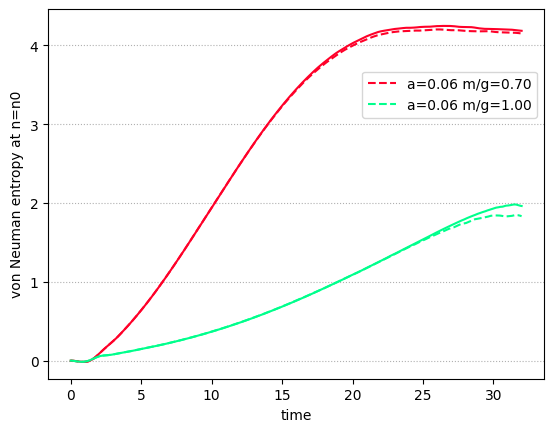

In [9]:
for j, (N, a, D, dt) in enumerate(NaDdt):
    for i, m in enumerate(ms):
        try:
            tm = data[m, N, a, D, dt]["time"]
            mask = tm > -1
            tm = tm[mask]
            ee = data[m, N, a, D, dt]["entropy_1"][mask]
            ee = ee - ee[0]
            line, = plt.plot(tm, ee[:, N // 2] , lines[j], color=colors[i])
            if save:
                np.savetxt(f'S_x=0_{m=:.2f}.txt', np.column_stack([tm[8:-1], ee[8:-1, N // 2]]))
            if j == 0:
                line.set_label(f"{a=:0.2f} {m/g=:0.2f}")
        except KeyError:
            pass


plt.grid(axis="y", linestyle=':')

plt.xlabel('time')
plt.ylabel('von Neuman entropy at n=n0')
plt.legend(ncols=1, bbox_to_anchor=(1, 0.85))

von Neuman entropy between left and right parts of the lattice; We subtract values in the initial state.

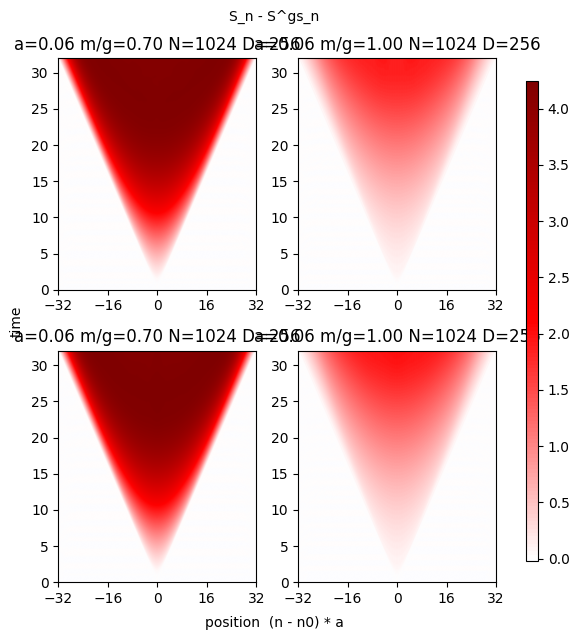

In [10]:
plot_heatmaps('entropy_1', 'S_n - S^gs_n', data, NaDdt, ms, g, subtract_t0=True, avarage_nn=False)

T00 - T00(t=0);  We might avarage over [2*l, 2*l+1] sites.


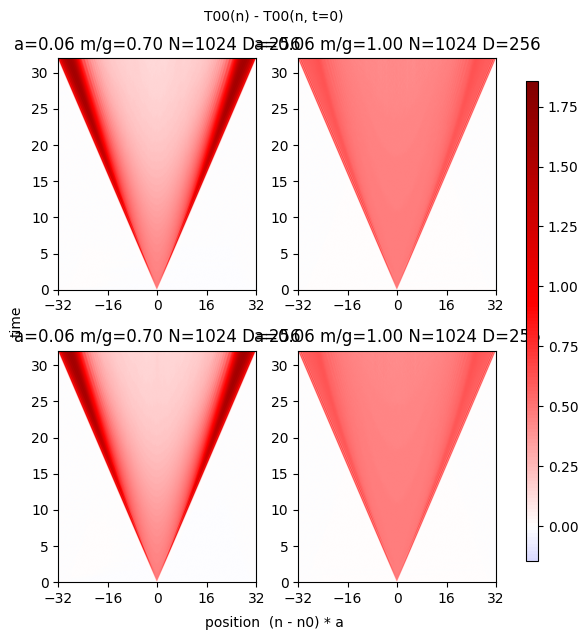

In [11]:
plot_heatmaps("T00", 'T00(n) - T00(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=True)  # None -> fT00,  for analytical m=0

T11; We avarage over [2*l, 2*l+1] sites, and subtract initial value.

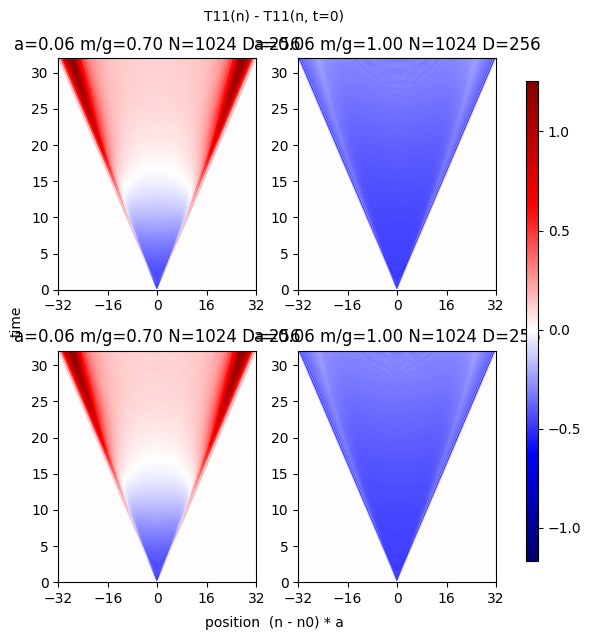

In [12]:
plot_heatmaps("T11", 'T11(n) - T11(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=True)  # None -> fT11,  for analytical m=0

T01 - T01(t=0); We can avarage over [2*l, 2*l+1] sites.

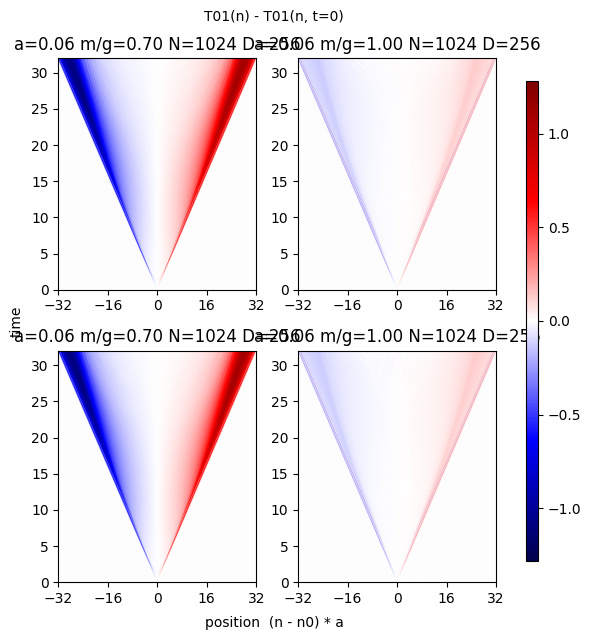

In [13]:
plot_heatmaps("T01", 'T01(n) - T01(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=True)  # fT01,

j0; subtract j0(t=0)

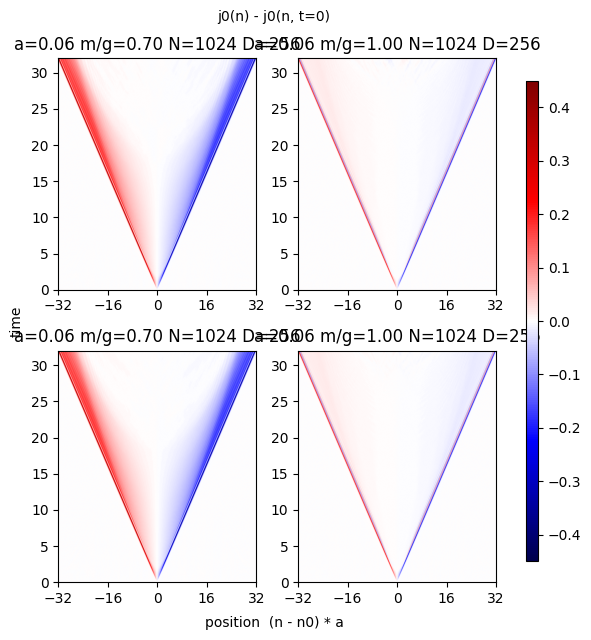

In [14]:
plot_heatmaps("j0", 'j0(n) - j0(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=False)  # fj0,

j1;

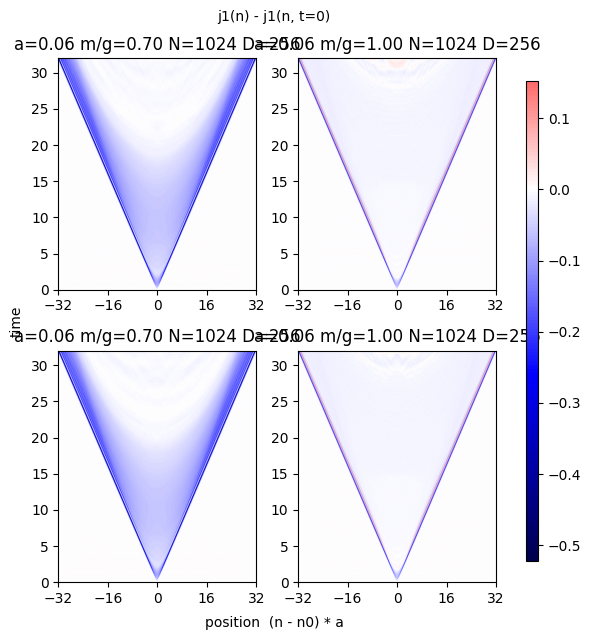

In [15]:
plot_heatmaps("j1", 'j1(n) - j1(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=False)  # fj1,

condensate

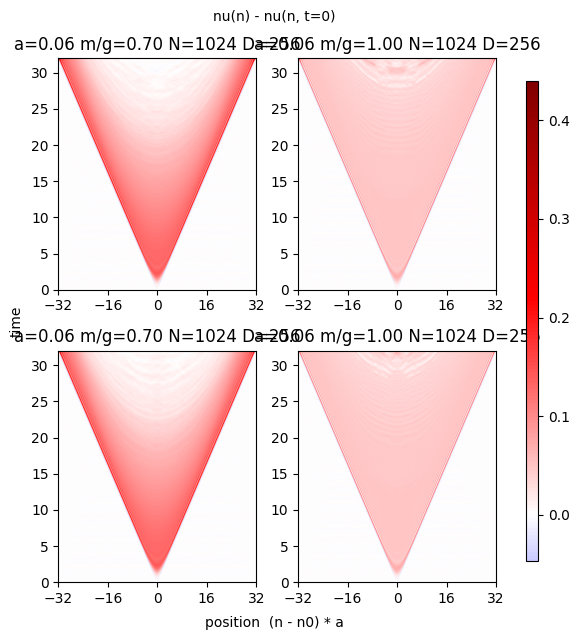

In [16]:
plot_heatmaps("nu", 'nu(n) - nu(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=False)  #  fnu,

Ln

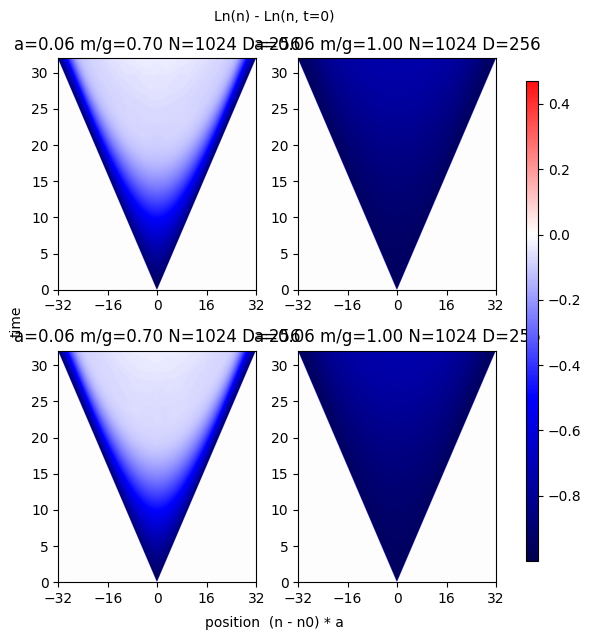

In [17]:
plot_heatmaps("Ln", 'Ln(n) - Ln(n, t=0)', data, NaDdt, ms, g, None, subtract_t0=True, avarage_nn=False)  # fLn,

In [18]:
NaDdt

[(1024, 0.0625, 256, 0.0625), (1024, 0.0625, 256, 0.03125)]

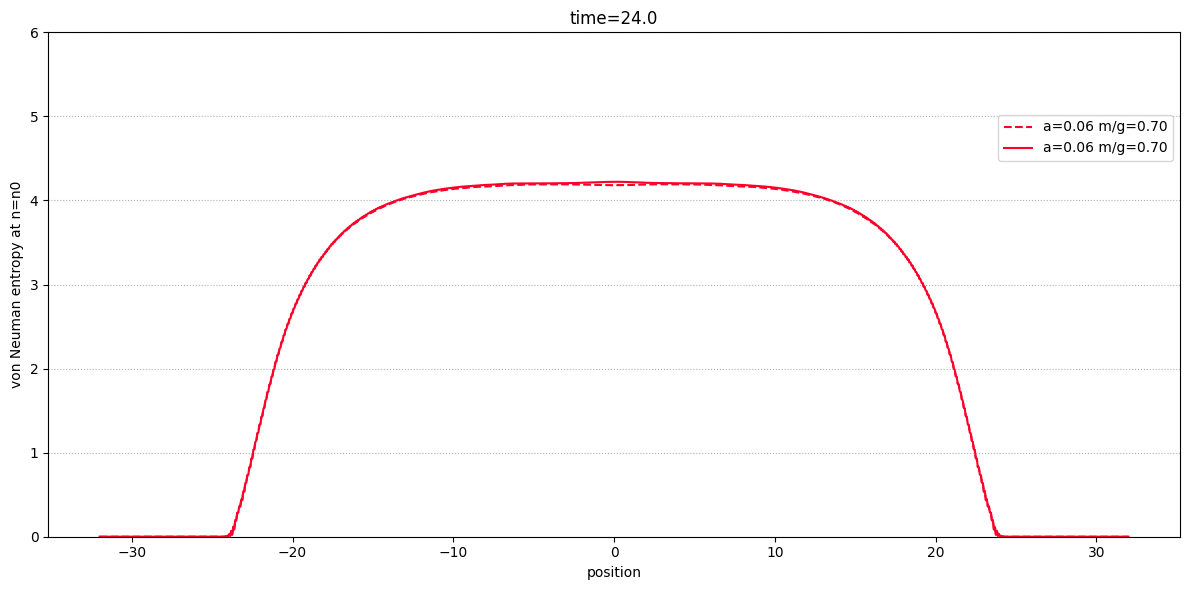

In [19]:
times = [24]

NaDdt

fig, ax = plt.subplots(len(times), 1, squeeze=False)
fig.set_size_inches(12, 6 * len(times))

for k, time in enumerate(times):
    for j, (N, a, D, dt) in enumerate(NaDdt[:]):
        for i, m in enumerate(ms[:1]):
            try:
                tm = data[m, N, a, D, dt]["time"]
                mask = tm > -1
                tm = tm[mask]

                ee = data[m, N, a, D, dt]["entropy_1"][mask]
                ee = ee - ee[0]

                ii = np.argmin(abs(tm - time))
                xx = np.linspace(-a * N / 2, a * N / 2, len(ee[ii, :]))

                if ii < len(tm) - 2:
                    line, = ax[k, 0].plot(xx, ee[ii, :] , lines[j], color=colors[i])
                    #if j == 0:
                    line.set_label(f"{a=:0.2f} {m/g=:0.2f}")
            except KeyError:
                pass

    ax[k, 0].grid(axis="y", linestyle=':')
    ax[k, 0].set_title(f'{time=:0.1f}')
    ax[k, 0].set_xlabel('position')
    ax[k, 0].set_ylabel('von Neuman entropy at n=n0')
    ax[k, 0].legend(ncols=1, bbox_to_anchor=(1, 0.85))
    ax[k, 0].set_ylim([0, 6])
fig.tight_layout()